In [39]:
import pandas as pd
import seaborn as sns
from pprint import pprint
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

In [40]:
plt.style.use('ggplot.mplstyle')

### Reading PyDamage results

In [41]:
df = pd.read_csv("../../data/ZSM028.pydamage.csv")

Looking at the effect of pred_accuracy on the number of contigs filtered

In [42]:
thresholds = [i.round(2) for i in np.arange(0,1,0.01)]

In [43]:
nb_contigs = list()
for i in thresholds:
    nb_contigs.append(df.query(f"pred_accuracy >= {i} & damage_model_p <= 0.6 & qvalue <= 0.05").shape[0])

Locating the [knee point](https://raghavan.usc.edu//papers/kneedle-simplex11.pdf): the optimal compromise  between sensitivity/specificity  
Selecting on the stricly decreasing part of the curve

In [44]:
from kneed import KneeLocator

In [45]:
x = thresholds[40:] 
y = nb_contigs[40:]
kneedle = KneeLocator(x,y, S=1.0, curve="convex", direction="decreasing")

In [46]:
kneedle.knee

0.67

/projects1/users/borry/15_miniconda3/envs/pydamage/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


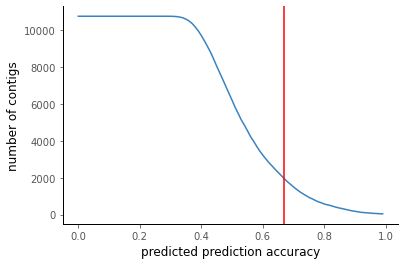

In [47]:
sns.lineplot(thresholds, nb_contigs, color='#3982BF')
plt.axvline(x=kneedle.knee, color='red')
plt.xlabel('predicted prediction accuracy')
plt.ylabel('number of contigs')
plt.savefig("../../plots/prediction_accuracy_thresholds.png", dpi=300)

### Filtering
- pred_accuracy >=0.67
- damage_model_p <= 0.6
- qvalue <= 0.05

In [48]:
df2 = df.query(f"pred_accuracy >= {kneedle.knee} & damage_model_p <= 0.6 & qvalue <= 0.05")

In [49]:
df['reference']

0           NODE_1_length_90306_cov_44.173087
1          NODE_1727_length_4002_cov_9.296689
2        NODE_13347_length_1166_cov_17.544157
3          NODE_1719_length_4030_cov_9.159097
4         NODE_1715_length_4034_cov_11.607420
                         ...                 
17056      NODE_9809_length_1401_cov_3.139381
17057     NODE_15388_length_1068_cov_3.272727
17058     NODE_12892_length_1188_cov_4.479440
17059     NODE_16059_length_1038_cov_4.948640
17060     NODE_12514_length_1209_cov_4.230241
Name: reference, Length: 17061, dtype: object

In [50]:
non_damaged_contigs = set(df['reference']).difference(set((df2['reference'])))

In [51]:
df2.reference.drop_duplicates()

0           NODE_1_length_90306_cov_44.173087
1          NODE_1727_length_4002_cov_9.296689
2        NODE_13347_length_1166_cov_17.544157
4         NODE_1715_length_4034_cov_11.607420
6         NODE_1711_length_4038_cov_11.491610
                         ...                 
12388     NODE_14800_length_1097_cov_2.879278
12480     NODE_17015_length_1003_cov_4.072025
12533     NODE_9664_length_1414_cov_24.268079
12622      NODE_6752_length_1752_cov_6.673111
12682      NODE_6672_length_1763_cov_4.934226
Name: reference, Length: 1944, dtype: object

### Distribution of the damage on the first base

<AxesSubplot:ylabel='Frequency'>

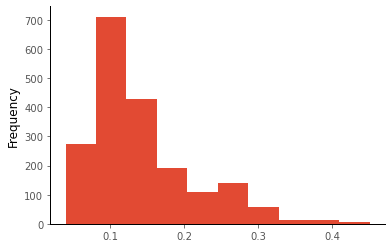

In [52]:
df2['damage_model_pmax'].plot.hist()

## Prokka functional annotation

Reading the Prokka results

In [53]:
prokka_dict = {}
with open("../../results/prokka/ZSM028.tbl", 'r') as f:
    i = 0
    for line in f:
        i += 1
        if line.startswith(">"):
            seqname = line.split()[1]
        elif "			locus_tag" in line:
            locus = line.split()[1]
            prokka_dict[locus] = {'sequence':seqname}
        elif "			product" in line:
            prokka_dict[locus]['product'] = " ".join(line.split()[1:])

In [54]:
prokka = pd.DataFrame(prokka_dict).transpose()

In [55]:
prokka.head()

,sequence,product
ILPPLFEM_00001,NODE_1_length_90306_cov_44.173087,hypothetical protein
ILPPLFEM_00002,NODE_1_length_90306_cov_44.173087,hypothetical protein
ILPPLFEM_00003,NODE_1_length_90306_cov_44.173087,hypothetical protein
ILPPLFEM_00004,NODE_1_length_90306_cov_44.173087,hypothetical protein
ILPPLFEM_00005,NODE_1_length_90306_cov_44.173087,hypothetical protein


In [56]:
prokka.shape

(9301, 2)

Combinining prokka and PyDamage results

In [57]:
df3 = df2.merge(prokka, left_on='reference', right_on='sequence')

In [58]:
prokka_contigs = df2.merge(prokka, left_on='reference', right_on='sequence', how='right').query("product != 'hypothetical protein'")['reference'].drop_duplicates()

In [59]:
df2.merge(prokka, left_on='reference', right_on='sequence', how='right')['reference'].drop_duplicates().shape

(1901,)

Looking for contigs with potential resistance

In [60]:
contig_of_interest = df3.query("product.str.contains('resistance')", engine='python')

In [61]:
contig_of_interest['reference'] = contig_of_interest[['reference','reflen','coverage','product']]['reference'].str.split("_", expand=True)[[0,1]].agg('_'.join, axis=1)

/projects1/users/borry/15_miniconda3/envs/pydamage/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [62]:
contig_of_interest[['reference','reflen','coverage','product']]

,reference,reflen,coverage,product
158,NODE_1676,4090,81.343,Fosmidomycin resistance protein
1563,NODE_2661,3058,91.480,Colistin resistance protein EmrA
1564,NODE_2661,3058,91.480,Colistin resistance protein EmrA
2411,NODE_215,13020,27.037,Daunorubicin/doxorubicin resistance ATP-bindin...
2631,NODE_204,13262,44.908,"Tetracycline resistance protein, class C"
2783,NODE_232,12485,31.866,Multidrug resistance protein MdtC
2784,NODE_232,12485,31.866,Multidrug resistance protein MdtA
3102,NODE_465,8695,37.516,Tetracycline resistance protein TetO
3985,NODE_832,6259,46.317,Cobalt-zinc-cadmium resistance protein CzcA
3986,NODE_832,6259,46.317,Cobalt-zinc-cadmium resistance protein CzcB


In [63]:
contig_of_interest[['reference','reflen','coverage','product']].shape

(23, 4)

In [64]:
contig_of_interest[['reference','reflen','coverage','product']].to_csv("../../results/prokka/resistance_damaged_genes.csv")

## General Summary statistics

- Damage on 5' end

In [65]:
df2['damage_model_pmax'].describe()

count    1944.000000
mean        0.142951
std         0.069033
min         0.040000
25%         0.095000
50%         0.121500
75%         0.173000
max         0.451000
Name: damage_model_pmax, dtype: float64

- Coverage

In [66]:
df2['coverage'].describe()

count    1944.000000
mean       65.560986
std        60.812019
min         6.052000
25%        31.733250
50%        58.992500
75%        80.330000
max      1579.827000
Name: coverage, dtype: float64

- reference length

In [67]:
df2['reflen'].describe()

count     1944.000000
mean      5212.139403
std       7650.269197
min       1002.000000
25%       1490.000000
50%       2391.000000
75%       5374.500000
max      90306.000000
Name: reflen, dtype: float64

In [68]:
def n50(list_of_lengths):
    """Calculate N50 for a sequence of numbers.
 
    Args:
        list_of_lengths (list): List of numbers.
 
    Returns:
        float: N50 value.
 
    """
    tmp = []
    for tmp_number in set(list_of_lengths):
            tmp += [tmp_number] * list_of_lengths.count(tmp_number) * tmp_number
    tmp.sort()
 
    if (len(tmp) % 2) == 0:
        median = (tmp[int(len(tmp) / 2) - 1] + tmp[int(len(tmp) / 2)]) / 2
    else:
        median = tmp[int(len(tmp) / 2)]
 
    return median

- N50

In [69]:
n50(list(df2['reflen'].values))

10805

In [70]:
c2t_cols = [f"CtoT-{i}" for i in range(36)]

### Plotting all damage profiles for filtered contigs

In [71]:
damage_mean = df2.loc[:,c2t_cols].mean().to_numpy()
damage_sd = df2.loc[:,c2t_cols].std().to_numpy()

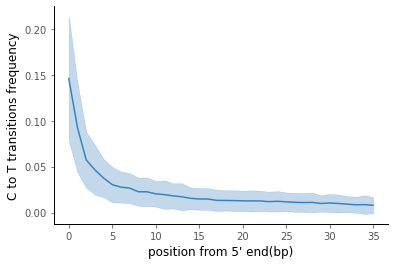

In [72]:
import numpy as np

lower_bound = damage_mean - damage_sd
upper_bound = damage_mean + damage_sd

x_axis = range(36)

sns.lineplot(x=x_axis, y=damage_mean, color='#3982BF')
plt.fill_between(x_axis, lower_bound, upper_bound, alpha=.3, color='#3982BF')
plt.xlabel("position from 5' end(bp)")
plt.ylabel("C to T transitions frequency")
plt.savefig("../../plots/contigs_damage.png", dpi=300)

Plotting all damage profiles for non filtered contigs

In [73]:
non_damage = df.query("qvalue > 0.05").loc[:,c2t_cols]

In [74]:
non_damage = df.query("reference in @non_damaged_contigs").loc[:,c2t_cols]

In [75]:
non_damage_mean = df.query("qvalue > 0.05").loc[:,c2t_cols].mean().to_numpy()
non_damage_sd = df.query("qvalue > 0.05").loc[:,c2t_cols].std().to_numpy()

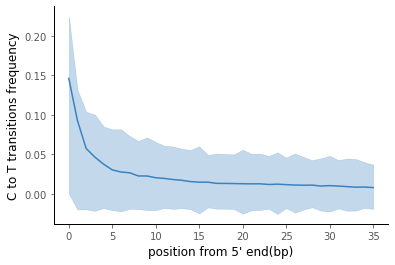

In [76]:
lower_bound = non_damage_mean - non_damage_sd
upper_bound = non_damage_mean + non_damage_sd

sns.lineplot(x=x_axis, y=damage_mean, color='#3982BF')
plt.fill_between(x_axis, lower_bound, upper_bound, alpha=.3, color='#3982BF')
plt.xlabel("position from 5' end(bp)")
plt.ylabel("C to T transitions frequency")
plt.savefig("../../plots/contigs_non_damage.png", dpi=300)